In [1]:
import numpy as np
import cvxpy as cp
import pickle
import matplotlib.pyplot as plt
import fdt_verification
from fdt_verification import *
from fdt_verification_z3 import *
from util import *

### Settings
- using more than the number of available cores will interfere with experiment timing
- timeout is in seconds for a single minimum adversarial perturbation or global robustness test

In [2]:
# using more workers than can be run concurrently will interfere with experiment timing
n_workers = 20
# timeout in seconds for single minimum adversrial perturbation or global robustness test
timeout = 3600
# tolerance for minimum adversarial perturbation tests
tol = 1e-3

In [3]:
# list of dataset names from OpenML
dataset_names = ["shuttle", "sylva_agnostic", "wall-robot-navigation", \
                "banknote-authentication", "helena", "MagicTelescope", \
                 "satimage", "texture", "JapaneseVowels", "hill-valley"]

### Check solvers and choose one

In [4]:
print(cp.installed_solvers())
# use Gurobi since it is more robust on the harder datasets
fdt_verification.solver = cp.GUROBI
# load the license so we don't get spammed with the notification in spawned processes
prob = cp.Problem(cp.Maximize(cp.Variable()), [])
prob.solve(solver=fdt_verification.solver)
pass

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'GUROBI', 'OSQP', 'SCS']
Restricted license - for non-production use only - expires 2022-01-13


### Check model sizes (same for both sigmoid and linear splitting)

In [5]:
for name in dataset_names:
    f = load_model(name + "_sigmoid")
    print("%s depth %d; %d nodes" % (name, *f.size()))

shuttle depth 4; 13 nodes
sylva_agnostic depth 7; 25 nodes
wall-robot-navigation depth 8; 33 nodes
banknote-authentication depth 6; 39 nodes
helena depth 7; 49 nodes
MagicTelescope depth 7; 57 nodes
satimage depth 11; 107 nodes
texture depth 14; 163 nodes
JapaneseVowels depth 12; 251 nodes
hill-valley depth 59; 305 nodes


# Minimum Adversarial Perturbation

### Our algorithm (sigmoid splitting)

In [ ]:
for name in dataset_names:
    f = load_model(name + "_sigmoid")
    x, y = load_robustness_test_points(name)
    perturbation, dist, exact, times = minimum_adversarial_perturbation(f, x, tol, n_workers=n_workers, timeout=timeout)
    pickle.dump((perturbation, dist, exact, times), open("results/map_" + name + "_sigmoid.pkl", "wb"))
    print(name)

### Our algorithm (linear splitting)

In [ ]:
for name in dataset_names:
    f = load_model(name + "_linear")
    x, y = load_robustness_test_points(name)
    perturbation, dist, exact, times = minimum_adversarial_perturbation(f, x, tol, n_workers=n_workers, timeout=timeout)
    pickle.dump((perturbation, dist, exact, times), open("results/map_" + name + "_linear.pkl", "wb"))
    print(name)

### Z3 (linear splitting)

In [ ]:
for name in dataset_names:
    f = load_model(name + "_linear")
    x, y = load_robustness_test_points(name)
    perturbation, dist, exact, times = minimum_adversarial_perturbation_z3(f, x, tol, n_workers=n_workers, timeout=timeout)
    pickle.dump((perturbation, dist, exact, times), open("results/map_" + name + "_z3.pkl", "wb"))
    print(name)

### Display results

sigmoid
-------
shuttle
100 within timeout; 100 within tolerance
mean 4.65; standard deviation 2.26
quartiles:	1.88	3.20	4.09	5.68	17.49
excluding Z3 fails and timeouts
mean 4.43; standard deviation 1.90
quartiles:	1.88	3.15	3.91	5.62	11.55

sylva_agnostic
97 within timeout; 97 within tolerance
mean 256.76; standard deviation 633.28
quartiles:	6.86	37.93	61.27	154.37	3600.00
excluding Z3 fails and timeouts
all Z3 cases failed or timed out

wall-robot-navigation
100 within timeout; 100 within tolerance
mean 12.40; standard deviation 16.48
quartiles:	0.55	4.28	8.20	12.31	129.75
excluding Z3 fails and timeouts
mean 7.09; standard deviation 5.54
quartiles:	0.55	3.20	5.01	9.63	23.10

banknote-authentication
100 within timeout; 100 within tolerance
mean 20.71; standard deviation 21.22
quartiles:	1.26	8.94	14.03	25.34	154.74
excluding Z3 fails and timeouts
mean 2.28; standard deviation 1.00
quartiles:	1.26	1.63	1.73	3.12	3.76

helena
100 within timeout; 100 within tolerance
mean 112.59; stand

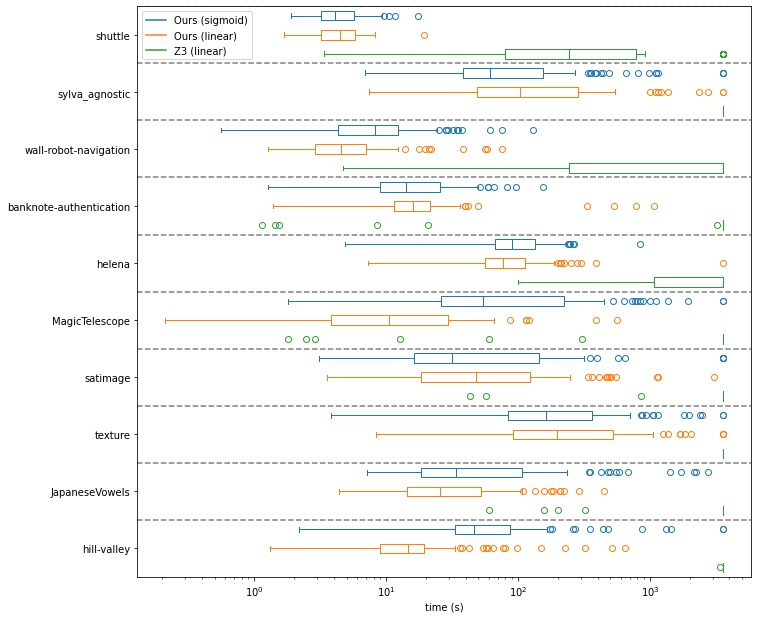

In [6]:
clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]

def set_box_color(bp, color):
    plt.setp(bp["boxes"], color=color)
    plt.setp(bp["whiskers"], color=color)
    plt.setp(bp["caps"], color=color)
    plt.setp(bp["medians"], color=color)
    plt.setp(bp["fliers"], markeredgecolor=color)

sig_timeses = []
lin_timeses = []
z3_timeses = []
for tag in ["sigmoid", "linear", "z3"]:
    print(tag)
    print("-"*len(tag))
    for name in dataset_names:
        perturbation, dist, exact, times = pickle.load(open("results/map_" + name + "_" + tag + ".pkl", "rb"))
        exact[times > timeout] = False
        times[times > timeout] = timeout
        if tag == "sigmoid": sig_timeses.append(times)
        if tag == "linear": lin_timeses.append(times)
        if tag == "z3": z3_timeses.append(times)
        print(name)
        print("%d within timeout; %d within tolerance" % (np.sum(times < timeout), np.sum(exact)))
        print("mean %.2f; standard deviation %.2f" % (np.mean(times), np.std(times)))
        print("quartiles:\t" + "\t".join(["%.2f"%t for t in np.quantile(times, [0, 0.25, 0.5, 0.75, 1])]))
        print("excluding Z3 fails and timeouts")
        _, _, z3exact, z3times = pickle.load(open("results/map_" + name + "_z3.pkl", "rb"))
        z3exact[z3times > timeout] = False
        times = times[z3exact]
        if times.shape[0] == 0:
            print("all Z3 cases failed or timed out")
        else:
            print("mean %.2f; standard deviation %.2f" % (np.mean(times), np.std(times)))
            print("quartiles:\t" + "\t".join(["%.2f"%t for t in np.quantile(times, [0, 0.25, 0.5, 0.75, 1])]))
        print("")
plt.figure(figsize=(11,10.5))
set_box_color(plt.boxplot(np.array(list(reversed(sig_timeses))).T, positions=[3*i+2 for i in range(len(dataset_names))], vert=False), clrs[0])
set_box_color(plt.boxplot(np.array(list(reversed(lin_timeses))).T, positions=[3*i+1 for i in range(len(dataset_names))], vert=False), clrs[1])
set_box_color(plt.boxplot(np.array(list(reversed(z3_timeses ))).T, positions=[3*i+0 for i in range(len(dataset_names))], vert=False), clrs[2])
for i in range(len(dataset_names)): plt.axhline(3*i+2.5, c="gray", ls="--")
plt.plot([], c=clrs[0], label="Ours (sigmoid)")
plt.plot([], c=clrs[1], label="Ours (linear)")
plt.plot([], c=clrs[2], label="Z3 (linear)")
plt.legend(loc="upper left")
plt.yticks([3*i+1 for i in range(len(dataset_names))], labels=np.array(list(reversed(dataset_names))))
plt.xlabel("time (s)")
plt.xscale("log")
plt.show()

# Global Adversarial Robustness

In [ ]:
delta = [1e-3, 1e-2, 1e-1, 1e0]
epsilon = [0.2, 0.4, 0.6, 0.8]
for name in dataset_names:
    f = load_model(name + "_sigmoid")
    results = global_robustness(f, delta, epsilon, timeout=timeout)
    pickle.dump(results, open("results/gar_" + name + "_sigmoid.pkl", "wb"))
    print(name)

In [7]:
for name in dataset_names:
    results = pickle.load(open("results/gar_" + name + "_sigmoid.pkl", "rb"))
    print(name)
    print("delta\tepsilon\trobust\ttime (s)")
    for res in results:
        print("\t".join((str(res[0]), str(res[1]), str(res[2]), "%.0f"%res[-1])))
    print("")

shuttle
delta	epsilon	robust	time (s)
0.001	0.2	True	1858
0.001	0.4	True	50
0.001	0.6	True	10
0.001	0.8	True	5
0.01	0.2	False	12
0.01	0.4	False	170
0.01	0.6	True	174
0.01	0.8	True	13
0.1	0.2	False	4
0.1	0.4	False	4
0.1	0.6	False	6
0.1	0.8	False	10
1.0	0.2	False	5
1.0	0.4	False	7
1.0	0.6	False	14
1.0	0.8	False	24

sylva_agnostic
delta	epsilon	robust	time (s)
0.001	0.2	None	3604
0.001	0.4	None	3604
0.001	0.6	True	909
0.001	0.8	True	56
0.01	0.2	None	3602
0.01	0.4	None	3604
0.01	0.6	True	1492
0.01	0.8	True	45
0.1	0.2	False	202
0.1	0.4	False	852
0.1	0.6	None	3604
0.1	0.8	None	3601
1.0	0.2	False	193
1.0	0.4	False	253
1.0	0.6	False	419
1.0	0.8	False	765

wall-robot-navigation
delta	epsilon	robust	time (s)
0.001	0.2	None	3601
0.001	0.4	None	3601
0.001	0.6	None	3602
0.001	0.8	True	585
0.01	0.2	None	3602
0.01	0.4	None	3602
0.01	0.6	None	3602
0.01	0.8	None	3602
0.1	0.2	None	3602
0.1	0.4	None	3602
0.1	0.6	None	3602
0.1	0.8	None	3602
1.0	0.2	False	410
1.0	0.4	False	410
1.0	0.6	False	427
1.0	0.8	Fal